# Workplace Setup

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings("ignore")
mdLog = pd.read_csv('mdlog.csv',index_col = 0)

# Q1

In [2]:
mdLog['spread'] = mdLog['ask'] - mdLog['bid']
mdLog['spread_d'] = mdLog['spread'].diff().apply(lambda x: round(x, 2))
mdLog['bid_d'] = mdLog['bid'].diff().apply(lambda x: round(x, 2))
mdLog['ask_d'] = mdLog['ask'].diff().apply(lambda x: round(x, 2))

print((mdLog['spread_d'] > 0).sum())
print((mdLog['spread_d'] < 0).sum())
print(((mdLog['spread_d'] > 0) & (mdLog['bid_d'] <0) & (mdLog['ask_d'] > 0)).sum())
print(((mdLog['spread_d'] > 0) & ((mdLog['bid_d'] <0) ^ (mdLog['ask_d'] > 0))).sum())

233
235
1
232


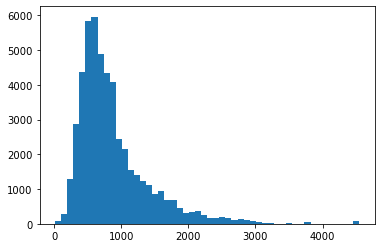

In [3]:
mdLog['market_size'] = (mdLog['bidsize'] + mdLog['asksize'])/2
plt.hist(mdLog['market_size'], bins = 50)
plt.show()

# Q2

In [4]:
mdLog.loc[:,'mid_price'] = (mdLog['ask'] + mdLog['bid'])/2
mdLog.loc[:,'mid_price_d'] = mdLog['mid_price'].diff()

mask = (mdLog['mid_price_d'] != 0) & (mdLog['spread_d'] == 0)
mdLog_mid_change = mdLog[mask]
mdLog_mid_change.loc[:,'aggresive_size'] = mdLog_mid_change.apply(lambda row: row['bidsize'] if row['mid_price_d'] > 0 else row['asksize'], axis = 1)
mdLog_mid_change.loc[:,'defensive_size'] = mdLog_mid_change.apply(lambda row: row['asksize'] if row['mid_price_d'] > 0 else row['bidsize'], axis = 1)

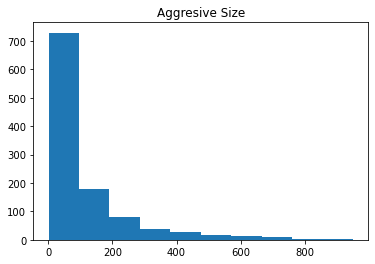

In [5]:
plt.hist(mdLog_mid_change['aggresive_size']);plt.title('Aggresive Size');plt.show()

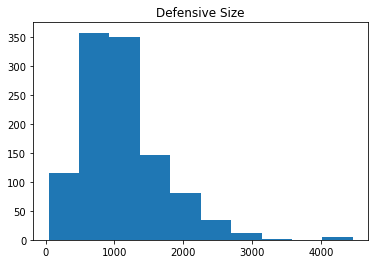

In [6]:
plt.hist(mdLog_mid_change['defensive_size']);plt.title('Defensive Size');plt.show()

# Q3

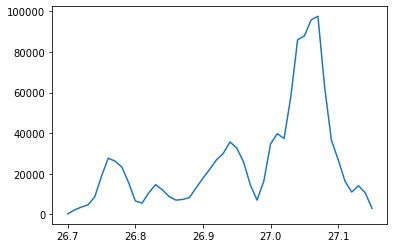

In [7]:
# mdLog['lastprice'].value_counts().index.tolist()
mdLog['trades'] = mdLog['volume'].diff()
volume_count = {}
for idx in range(2,len(mdLog)):
    cur_price = round(mdLog.loc[idx,'lastprice'],2)
    last_price = round(mdLog.loc[idx,'lastprice'],2)
    trades = mdLog.loc[idx,'trades']
    lo = min(cur_price,last_price)
    hi = max(cur_price,last_price)
    num_levels = (hi-lo+0.01)/0.01
    for price in np.arange(lo,hi+0.01,0.01):
        price = round(price,2)
        volume_count[price] = volume_count.get(price,0) + trades / num_levels

volume_count = pd.Series(volume_count).sort_index()
volume_count.plot()

In [8]:
mdLog['lastprice_d'] = mdLog['lastprice'].diff() 
mdLog['trade_at_last_price'] = mdLog['trades'] / (abs(mdLog['lastprice'].diff()/0.01) + 1) 

# Q4

In [9]:
mdLog['sizeDeltaAtBid'] = mdLog['bidsize'].diff() +  mdLog['trade_at_last_price']
mdLog.loc[mdLog['bid_d'] != 0,'sizeDeltaAtBid'] = 0

mdLog['sizeDeltaAtAsk'] = mdLog['asksize'].diff() +  mdLog['trade_at_last_price']
mdLog.loc[mdLog['ask_d'] != 0,'sizeDeltaAtAsk'] = 0

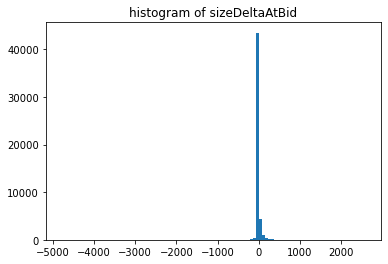

In [10]:
plt.hist(mdLog['sizeDeltaAtBid'], bins = 100);plt.title('histogram of sizeDeltaAtBid');plt.show()

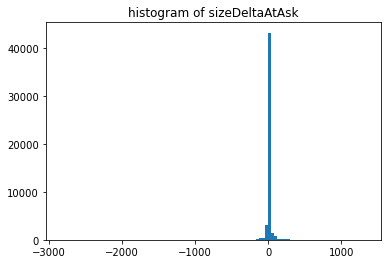

In [11]:
plt.hist(mdLog['sizeDeltaAtAsk'], bins = 100);plt.title('histogram of sizeDeltaAtAsk');plt.show()

# Q5

In [12]:
num_top_order = 0
num_entire_BBO = 0
num_entire_BBO_and_filled_original = 0
list_of_satisfied_top_orders = [] #(start_idx, end_idx, order_type,start_size)
idx = 1
while (idx < len(mdLog)):
    if mdLog.loc[idx,'mid_price_d'] > 0 and mdLog.loc[idx,'sizeDeltaAtBid'] > 0:
        #aggresive_side was bid as the mid price went up
        start_idx = copy.deepcopy(idx)
        order_type = 'bid'
        num_top_order += 1
        num_entire_BBO += 1
        order_size = mdLog.loc[idx,'sizeDeltaAtBid']
        start_size = copy.deepcopy(order_size)
        order_price = mdLog.loc[idx,'bid']
        original_size = True
        entire_BBO = True
        idx += 1
        while(order_size > 0):
            bid_price = mdLog.loc[idx,'bid']
            last_price = mdLog.loc[idx,'lastprice']
            if bid_price > order_price:
                num_entire_BBO -= 1
                entire_BBO = False
                break
                # As we only need to consider top orders that spend entire life on BBO in q5 and q6 we could break internal loop when it no longer was the BBO
                # I considered adding the following criterion, which I believe is the ultimately true one, but results in very small number of observations (num_entire_BBO = 2). We could discuss in the future interviews
                # if bid_price == order_price and last_price > order_price:
                # during a very short interval someone submitted a higher bid and traded, thus the focus order was not BBO during that interval
            elif bid_price == order_price:
                # At BBO
                trades = mdLog.loc[idx,'trades']
                if trades < order_size:
                    # partially filled
                    order_size -= trades
                else:
                    # totally filled
                    # if trades == order_size, it is undoubtly correct to do so
                    # if trades > order_size, I assume the original order was filled and there were more orders submitted at BBO that were also filled
                    order_size = 0
                    break
                bid_size = mdLog.loc[idx,'bidsize']
                if bid_size < order_size:
                    # after calculating trade, bid_size < order_size
                    # the top order was partially cancelled and thus not fully filled
                    original_size = False
                    order_size = bid_size
            else:
                # bid_price < order_price while order_size > 0:
                # we need to consider whether the top order was fully filled during the change
                # although we could use the allocation method mentioned in q3, we should not be contrained here and simply compare the total trades happened in between 
                # and the remaining order size
                if mdLog.loc[idx,'trades'] <= order_size:
                    original_size = False
                    break
            idx+=1
        if entire_BBO and original_size:
            num_entire_BBO_and_filled_original +=1
            list_of_satisfied_top_orders.append((start_idx, idx, order_type,start_size))
        

    elif mdLog.loc[idx,'mid_price_d'] < 0 and mdLog.loc[idx,'sizeDeltaAtAsk'] > 0:
        #aggressive side was ask
        start_idx = copy.deepcopy(idx)
        order_type = 'ask'
        num_top_order += 1
        num_entire_BBO += 1
        order_size = mdLog.loc[idx,'sizeDeltaAtAsk']
        start_size = copy.deepcopy(order_size)
        order_price = mdLog.loc[idx,'ask']
        original_size = True
        idx += 1
        while(order_size > 0):
            ask_price = mdLog.loc[idx,'ask']
            if ask_price < order_price:
                num_entire_BBO -= 1 
                entire_BBO = False
                break
            elif ask_price == order_price:
                # At BBO
                trades = mdLog.loc[idx,'trades']
                if trades < order_size:
                    # partially filled
                    order_size -= trades
                else:
                    order_size = 0
                    break
                ask_size = mdLog.loc[idx,'asksize']
                if ask_size < order_size:
                    original_size = False
                    order_size = ask_size
            else:
                if mdLog.loc[idx,'trades'] <= order_size:
                    original_size = False
                    break
            idx+=1
        if entire_BBO and original_size:
            num_entire_BBO_and_filled_original +=1
            list_of_satisfied_top_orders.append((start_idx, idx, order_type,start_size))
    
    else:
        idx += 1


In [13]:
print(num_top_order)
print(num_entire_BBO)
print(num_entire_BBO_and_filled_original)
print(len(list_of_satisfied_top_orders))

181
57
30
30


# Q6

In [14]:
return_list = []
top_order_size = []
size_delta_two_after = []
for top_order in list_of_satisfied_top_orders:
    order_start = top_order[0]
    order_end = top_order[1]
    order_type = top_order[2]
    order_size = top_order[3]
    top_order_size.append(order_size)
    if order_type == 'bid':
        order_price = mdLog.loc[order_start, 'bid']
        mid_price_20_after = mdLog.loc[order_end + 20, 'mid_price']
        return_list.append((mid_price_20_after - order_price) * 100)
        size_delta_two_after.append(mdLog.loc[order_start + 2, 'sizeDeltaAtBid'])
    if order_type == 'ask':
        order_price = mdLog.loc[order_start, 'ask']
        mid_price_20_after = mdLog.loc[order_end + 20, 'mid_price']
        return_list.append((order_price-mid_price_20_after) * 100)
        size_delta_two_after.append(mdLog.loc[order_start + 2, 'sizeDeltaAtAsk'])

In [15]:
np.mean(return_list)

1.0166666666666775

# Q8

In [16]:
Y = pd.Series(return_list)
X = pd.DataFrame([top_order_size,size_delta_two_after]).T
X.columns = ['top_order_size', 'size_delta_two_after']

sm.OLS(Y,sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.053
Method:                 Least Squares   F-statistic:                    0.2691
Date:                Fri, 24 Sep 2021   Prob (F-statistic):              0.766
Time:                        22:54:06   Log-Likelihood:                -33.068
No. Observations:                  30   AIC:                             72.14
Df Residuals:                      27   BIC:                             76.34
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0561      0.170      6.205      0.000       0.707       1.405
top_order_size          -0.0014      0.003     -0.484      0.632      -0.007       0.004
size_delta_two_after     0.0028      0.005      0.616      0.543      -0.007       0.012
==============================================================================
Omnibus:                        0.385   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.825   Jarque-Bera (JB):                0.154
Skew:                          -0.173   Prob(JB):                        0.926
Kurtosis:                       2.937   Cond. No.                         74.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
mdLog.to_csv('mdLog_modified.csv')